In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
conflict_df = pd.read_csv("conflict_intensity.csv")
crop_cover_df = pd.read_csv("tile_crop_cover_all_years.csv")

In [3]:
conflict_df

,Unnamed: 0,tile_id,year,conflict_intensity
0,0,93946_988825,2020,0.0
1,1,93946_1013825,2020,0.0
2,2,93946_1038825,2020,0.0
3,3,93946_1063825,2020,0.0
4,4,93946_1088825,2020,0.0
...,...,...,...,...
2830,2830,593946_1538825,2024,0.0
2831,2831,593946_1563825,2024,0.0
2832,2832,593946_1588825,2024,0.0
2833,2833,593946_1613825,2024,0.0


In [4]:
# First, identify tiles that had >= 1000 ha crop cover in 2019
baseline_year = 2019

# Get crop area in 2019 for each tile
crop_2019 = crop_cover_df[crop_cover_df['year'] == baseline_year][['tile_id', 'area_ha']]
crop_2019 = crop_2019.rename(columns={'area_ha': 'area_ha_2019'})

# Identify tiles with >= 1000 ha in 2019
valid_tiles = crop_2019[crop_2019['area_ha_2019'] >= 1000]['tile_id']

# Filter crop_cover_df to only include valid tiles
crop_cover_df_filtered = crop_cover_df[crop_cover_df['tile_id'].isin(valid_tiles)].copy()

# Now calculate crop_cover_change_df from filtered data
crop_cover_df_sorted = crop_cover_df_filtered.sort_values(['tile_id', 'year'])

# Calculate year-over-year change in crop area
crop_cover_df_sorted['crop_change_ha'] = crop_cover_df_sorted.groupby('tile_id')['area_ha'].diff()

# Calculate percentage change
crop_cover_df_sorted['crop_change_pct'] = (
    crop_cover_df_sorted.groupby('tile_id')['area_ha'].pct_change() * 100
)

# Remove rows where there's no previous year
crop_cover_change_df = crop_cover_df_sorted.dropna(subset=['crop_change_ha']).copy()

# Keep relevant columns
crop_cover_change_df = crop_cover_change_df[['tile_id', 'year', 'area_ha', 'crop_change_ha', 'crop_change_pct']]
crop_cover_change_df

,tile_id,year,area_ha,crop_change_ha,crop_change_pct
1,118946_1013825,2020,4637.463686,-2050.727569,-30.661916
2,118946_1013825,2021,5145.763020,508.299333,10.960718
3,118946_1013825,2022,3978.541451,-1167.221569,-22.683158
4,118946_1013825,2023,4400.650510,422.109059,10.609643
5,118946_1013825,2024,3930.142392,-470.508118,-10.691786
...,...,...,...,...,...
3397,93946_988825,2020,2233.924039,-901.906196,-28.761321
3398,93946_988825,2021,2873.754902,639.830863,28.641568
3399,93946_988825,2022,2264.106627,-609.648275,-21.214345
3400,93946_988825,2023,1468.365137,-795.741490,-35.145937


In [5]:
conflict_and_crop_df = conflict_df.merge(
    crop_cover_change_df[['tile_id', 'year', 'crop_change_ha', 'crop_change_pct']],
    on=['tile_id', 'year'],
    how='left'
)
conflict_and_crop_df

,Unnamed: 0,tile_id,year,conflict_intensity,crop_change_ha,crop_change_pct
0,0,93946_988825,2020,0.0,-901.906196,-28.761321
1,1,93946_1013825,2020,0.0,-763.185059,-9.353965
2,2,93946_1038825,2020,0.0,-889.135098,-18.639702
3,3,93946_1063825,2020,0.0,-2829.002784,-11.102661
4,4,93946_1088825,2020,0.0,-1481.545098,-15.152124
...,...,...,...,...,...,...
2830,2830,593946_1538825,2024,0.0,NaN,NaN
2831,2831,593946_1563825,2024,0.0,NaN,NaN
2832,2832,593946_1588825,2024,0.0,NaN,NaN
2833,2833,593946_1613825,2024,0.0,NaN,NaN


In [6]:
# Drop rows where crop_change_ha is 0 or missing
conflict_and_crop_df = conflict_and_crop_df[
    (conflict_and_crop_df['crop_change_ha'] != 0) & 
    (conflict_and_crop_df['crop_change_ha'].notna())
]

In [7]:
conflict_and_crop_df = conflict_and_crop_df[conflict_and_crop_df["crop_change_pct"] < 100]

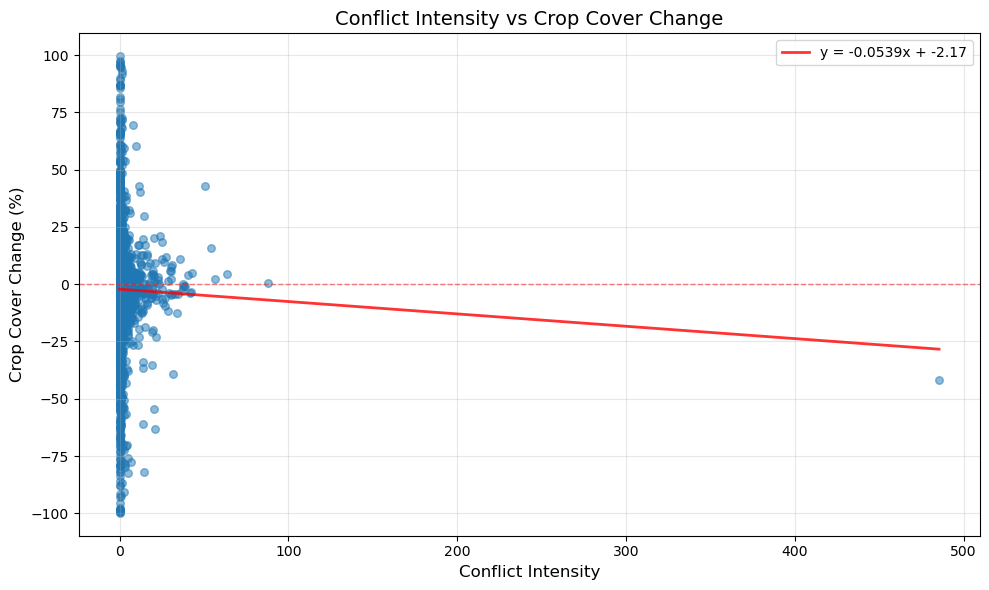

Regression line: y = -0.0539x + -2.17


In [8]:
# Create scatterplot
plt.figure(figsize=(10, 6))

plt.scatter(
    conflict_and_crop_df['conflict_intensity'],
    conflict_and_crop_df['crop_change_pct'],
    alpha=0.5,
    s=30
)

plt.xlabel('Conflict Intensity', fontsize=12)
plt.ylabel('Crop Cover Change (%)', fontsize=12)
plt.title('Conflict Intensity vs Crop Cover Change', fontsize=14)

# Add horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Add regression line
z = np.polyfit(conflict_and_crop_df['conflict_intensity'], 
               conflict_and_crop_df['crop_change_pct'], 1)
p = np.poly1d(z)
x_line = np.linspace(conflict_and_crop_df['conflict_intensity'].min(), 
                     conflict_and_crop_df['conflict_intensity'].max(), 100)
plt.plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.2f}')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print regression line equation
print(f"Regression line: y = {z[0]:.4f}x + {z[1]:.2f}")